**Copyright 2021 Commplax authors**

Licensed under the Apache License, Version 2.0 (the "License");

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

#Hello World in commplax

## Install dependencies (expand sub-cell to see details)

### Install [Commplax](https://github.com/remifan/commplax)

In [ ]:
!pip install --upgrade pip
!pip install --upgrade jax==0.2.13 jaxlib==0.1.66+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html # optional GPU lib
!pip install http://github.com/remifan/commplax/archive/master.zip

     |████████████████████████████████| 1.6MB 8.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     | 285 kB 339 kB/s
     |████████████████████████████████| 183 kB 8.3 MB/s 
     |████████████████████████████████| 118 kB 15.9 MB/s 
     |████████████████████████████████| 57 kB 5.8 MB/s 
  Created wheel for commplax: filename=commplax-0.1.1-py3-none-any.whl size=48530 sha256=c7c21bda904229c27347efe48abc43a4c4debf8e7a9c01af774849919cec6d77
  Stored in directory: /tmp/pip-ephem-wheel-cache-jnzn1wf_/wheels/55/d9/66/94086f5ebbe5c8a2a571fe03d8bc7609999191b7a642382190
  Created wheel for quantumrandom: filename=quantumrandom-1.9.0-py3-none-any.whl size=9131 sha256=44b4ce48f768ccb1dbb29a9b2cada355981cdd93fcb1b3529b4d895a30ba0ed1
  Stored in directory: /root/.cache/pip/wheels/99/08/4f/618080011e884de267d956ba1e96144f1071417dd75f480de4
Successf

### Install DVC

In [ ]:
!pip install dvc[s3]

     |████████████████████████████████| 637 kB 9.2 MB/s 
     |████████████████████████████████| 529 kB 56.6 MB/s 
     |████████████████████████████████| 44 kB 3.3 MB/s 
     |████████████████████████████████| 207 kB 58.4 MB/s 
     |████████████████████████████████| 40 kB 6.9 MB/s 
     |████████████████████████████████| 4.6 MB 52.5 MB/s 
     |████████████████████████████████| 296 kB 66.8 MB/s 
     |████████████████████████████████| 170 kB 69.6 MB/s 
     |████████████████████████████████| 49 kB 7.5 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
     |████████████████████████████████| 115 kB 64.5 MB/s 
     |████████████████████████████████| 108 kB 67.5 MB/s 
     |████████████████████████████████| 48 kB 6.1 MB/s 
     |████████████████████████████████| 7.4 MB 5.1 MB/s 
     |████████████████████████████████| 1.3 MB 54.1 MB/s 
     |████████████████████████████████| 131 kB 65.4 MB/s 
     |████████████████████████████████| 73 kB 2.2 MB/s 
     |██████████████████████

## Download transmission data

In [ ]:
!dvc get https://github.com/remifan/LabPtPTm1 data/815km_SSMF/DP16QAM_RRC0.2_28GBd_1ch/LP-6_5.h5
!dvc get https://github.com/remifan/LabPtPTm1 data/source/16QAM65536_mt19937ar_src1.h5

## Demodulate DP-16QAM ~815km SSMF transmission signal using commplax

In [ ]:
from jax import numpy as jnp, jit
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import h5py
from commplax import xop, comm, xcomm, adaptive_filter as af, equalizer as eq, plot as cplt

### Preprocessing

In [ ]:
with h5py.File("LP-6_5.h5", "r") as hf:
  y = hf['recv'][...]
  sr = hf.attrs['samplerate']
  br = hf.attrs['baudrate']
  dist = hf.attrs['distance']
  spans = hf.attrs['spans']
  lpw = hf.attrs['lpw']
  mf = hf.attrs['modformat']

with h5py.File("16QAM65536_mt19937ar_src1.h5", "r") as hf:
  x = hf['sent'][...]

# meta data
print('shape of y: %s (preprocessed waveforms, resampled to 2 samples/symbol): ' % str(y.shape))
print('shape of x: %s (sent symbols, emulating PDM by delaying 1 polarization): ' % str(x.shape))
print('sample rate: %.1f GHz' % (sr / 1e9))
print('baud rate: %.1f GBd' % (br / 1e9))
print('launched power: %.3f mW' % (lpw * 1e3))
print('link distance: %.1f km (measured)' % (dist / 1e3))
print('number of spans: %d' % spans)

shape of y: (3500000, 2) (preprocessed waveforms, resampled to 2 samples/symbol): 
shape of x: (65536, 2) (sent symbols, emulating PDM by delaying 1 polarization): 
sample rate: 56.0 GHz
baud rate: 28.0 GBd
launched power: 0.871 mW
link distance: 815.0 km (measured)
number of spans: 10


In [ ]:
# DC-block and normalize raw signal
y -= np.mean(y, axis=0)
y =  xcomm.normpower(y, real=True) / np.sqrt(2)
 
# mesuaring CD. first time run could be slightly slow to warmup GPU
CD = xcomm.measure_cd(y[10000:30000, 0], sr, bins=2000)[0]
print('estimated accumulated CD = %.4g s/m' % CD)

estimated accumulated CD = 13.6 s/m


### A minimal example of blind equalization using `equalizer` interface

In [ ]:
z = eq.cdcomp(y, sr, CD, taps=501)  # CD compensaton
z = eq.modulusmimo(z, taps=19, lr=2**-15)[0]  # polarization demultiplexing
z = eq.qamfoe(z)[0]  # frequency offset equalization
x_hat = eq.ekfcpr(z)[0]  # carrier phase recovery

showing 10000 out of 1750000 recovered symbols


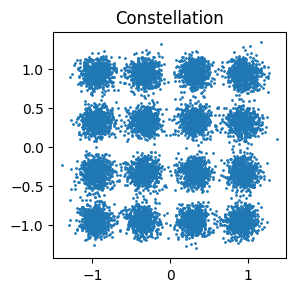

In [ ]:
print(f'showing 10000 out of {x_hat.shape[0]} recovered symbols')
cplt.scatter(x_hat[100000:110000,0])

In [ ]:
# aligning sent symbols to calc. BER
z = xcomm.repalign(x_hat, x, skipfirst=len(x_hat) - 100000)

# removing phase ambiguity and rescale signal
x_hat = xcomm.alignphase(x_hat, z) * xcomm.qamscale(mf)

# get metrics
qot = comm.qamqot(x_hat, z, eval_range=(500000, -20000))
qot

,BER,QSq,SNR
dim0,0.000520,10.316206,17.188946
dim1,0.000201,10.975679,17.989663
total,0.000361,10.581768,17.570875


### Equivalent steps based on lower level `adaptive_filter` and `xcomm` interfaces

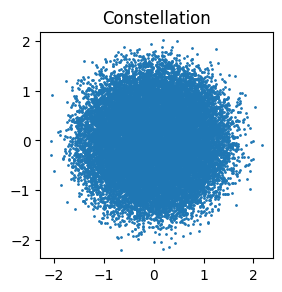

In [ ]:
# 1 step/span time domain digital back propogation

D_fir_taps = 301  # number of taps for CD compensation operator (namely D op.)
NLC_factor = 0.  # DBP NL calibration factor, 0 accounts for CD compensation only
param_D, param_N = comm.dbp_params(sr, dist/spans, spans, D_fir_taps, fiber_dispersion=CD / dist)
y_dbp = xcomm.dbp_timedomain(y / jnp.sqrt(2), param_D, NLC_factor * lpw * 1e3 * param_N) * jnp.sqrt(2)

# scatterplot X-Pol signal to compared with the ones shown below
cplt.scatter(y_dbp[1000000:1020000, 0])

In [ ]:
# make adaptive filters' functonal utilies
cma_init, cma_update, cma_map = af.mucma()
rde_init, rde_update, rde_map = af.rde()
# create 2-cpr AF array with each cpr module implemented dimention(pol.)-wise 
cpr_init, cpr_update, cpr_map = af.array(af.cpane_ekf, 2)()

iterate = jit(af.iterate, backend='cpu', static_argnums=0)

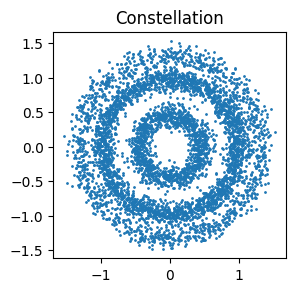

In [ ]:
taps = 19  # MIMO filter tap number
sps = 2  # T/2-spaced adaptive equalizer

# framing signal to enable map function
yf = jnp.array(xop.frame(y_dbp, taps, sps))

# get initial weights
s0 = cma_init(taps=19)
# warm-up MIMO via CMA using a short sequence
(w0, *_,), (ws1, loss1) = iterate(cma_update, 0, s0, yf[:20000])[1]
# switch to RDE that inherits CMA'weights
_, (ws2, loss2) = iterate(rde_update, 0, w0, yf[20000:])[1]
# map to get MIMO out
loss = jnp.concatenate([loss1, loss2], axis=0)
ws = jnp.concatenate([ws1, ws2], axis=0)
x_hat = rde_map(ws, yf)

cplt.scatter(x_hat[500000:505000, 1])

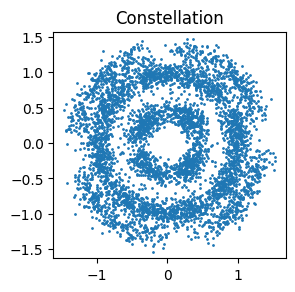

In [ ]:
# Frequency-offset coarse compensation using simple 4th-power-fft-max method
fo, fo_metric = xcomm.foe_mpowfftmax(x_hat[100000:200000], M=4)
fo = jnp.mean(fo) # average estimated FO from X and Y pol.
T = jnp.arange(len(x_hat))
x_hat *= jnp.tile(jnp.exp(-1j * fo * T)[:, None], (1, 2))

cplt.scatter(x_hat[500000:505000, 0])

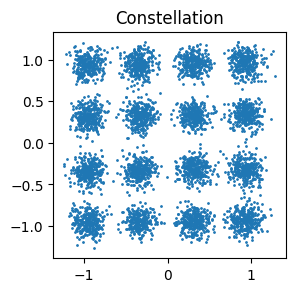

In [ ]:
# residual FO removal, carrier phase recovery via 1-tap CPANE-EKF
cpr_state = cpr_init()
cpr_update, (phi, cpr_decision) = iterate(cpr_update, 0, cpr_state, x_hat)[1]
x_hat = cpr_map(phi, x_hat)

# scatterplot signal after this stage
cplt.scatter(x_hat[500000:505000, 0])

X/Y delay from PDME: -408


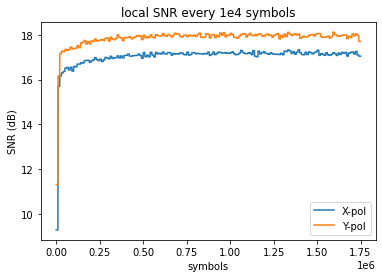

,BER,QSq,SNR
dim0,0.000526,10.308058,17.168629
dim1,0.000200,10.980266,17.970002
total,0.000363,10.577597,17.550859


In [ ]:
# check if singularity is present
print("X/Y delay from PDME: %d" % (xcomm.dimsdelay(x_hat)))

# synchronize sent symbols
z = xcomm.repalign(x_hat, x, skipfirst=len(x_hat) - 100000)

# remove phase ambiguity and rescale signal
x_hat = xcomm.alignphase(x_hat, z) * xcomm.qamscale(mf)

# check DSP convergence
snr_local = comm.qamqot_local(x_hat, z)['SNR'][:, :2]
fig = plt.figure()
plt.plot(snr_local)
plt.title('local SNR every 1e4 symbols')
plt.xlabel('symbols')
plt.ylabel('SNR (dB)')
plt.legend(['X-pol', 'Y-pol']);
plt.show()

# calc. effecitve QoT (BER, Q-factor (dB) and SNR (dB))
# %load_ext google.colab.data_table
comm.qamqot(x_hat[500000:-20000], z[500000:-20000])